# Exploring Monte Carlo (MC) and Monte Carlo Markov Chain (MCMC) Methods 🤔

### Author

- Alex Lavaee

### Collaborators

- None


In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
from scipy import stats
from tqdm.notebook import trange
from utils.d_ball_volume import volume_ball_analytical, volume_ball_monte_carlo
from utils.numerical_integration import MonteCarlo, NormalPrior, UniformPrior

# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.set_option("display.max_columns", 200)
plt.style.use("seaborn-v0_8-notebook")
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "text.latex.preamble": r"\usepackage{amsmath}",
    }
)

In [2]:
%load_ext autoreload
%autoreload explicit
%aimport utils

## Numerical integration ∭

References:

- https://en.wikipedia.org/wiki/Normal_distribution
- https://en.wikipedia.org/wiki/Monte_Carlo_integration
- https://prappleizer.github.io/Tutorials/MetropolisHastings/MetropolisHastings_Tutorial.html
- https://acme.byu.edu/0000017a-1bb8-db63-a97e-7bfa0bea0000/vol1lab16montecarlo2-pdf

The volume of an $n$-ball of radius $r$ is given by the formula:

\begin{equation*}
V_n = \frac{\pi^{n/2}}{\Gamma(n/2+1)} r^n
\end{equation*}

where $\Gamma$ is the gamma function.


I will be approximating the integral of the standard normal distribution using Monte Carlo methods. The standard normal distribution is given by the formula:

\begin{equation*}
f(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}
\end{equation*}


In [3]:
def func(x: np.ndarray) -> np.ndarray:
    return stats.norm.pdf(x, loc=0, scale=1)

I will first attempt to integrate the standard normal distribution using a naive Monte Carlo method that uses a uniform prior to sample points. Once points are sampled, I will use the formula:

\begin{equation*}
\int*a^b f(x) dx \approx \frac{1}{N} \sum*{i=1}^N f(x_i)
\end{equation*}

where $x_i$ are the sampled points. Conceptually, this is equivalent to taking random rectangles and averaging the area of the rectangles to approximate the area under the curve (see visual below):

<figure>
    <img src="./assets/integral_rectangle.png" alt="Integral Rectangle" style="width: 35em">
    <figcaption>Figure 1: Approximating the integral of a function using rectangles</figcaption>
</figure>


In [4]:
sampler = MonteCarlo()

sampler.set_target_distribution(func)

step_size = 0.05
lower_bound = -5
upper_bound = 5
num_steps = int((upper_bound - lower_bound) / step_size)
prior = UniformPrior(a=lower_bound, b=upper_bound)
cdf = np.zeros(num_steps)
for i in range(num_steps):
    new_a = lower_bound + step_size * i
    new_b = lower_bound + step_size * (i + 1)
    sampler.initialize(
        new_a,
        new_b,
        prior=prior,
        n_steps=1000,
    )
    pred = sampler.sample()
    cdf[i] = pred + cdf[i - 1] if i > 0 else pred

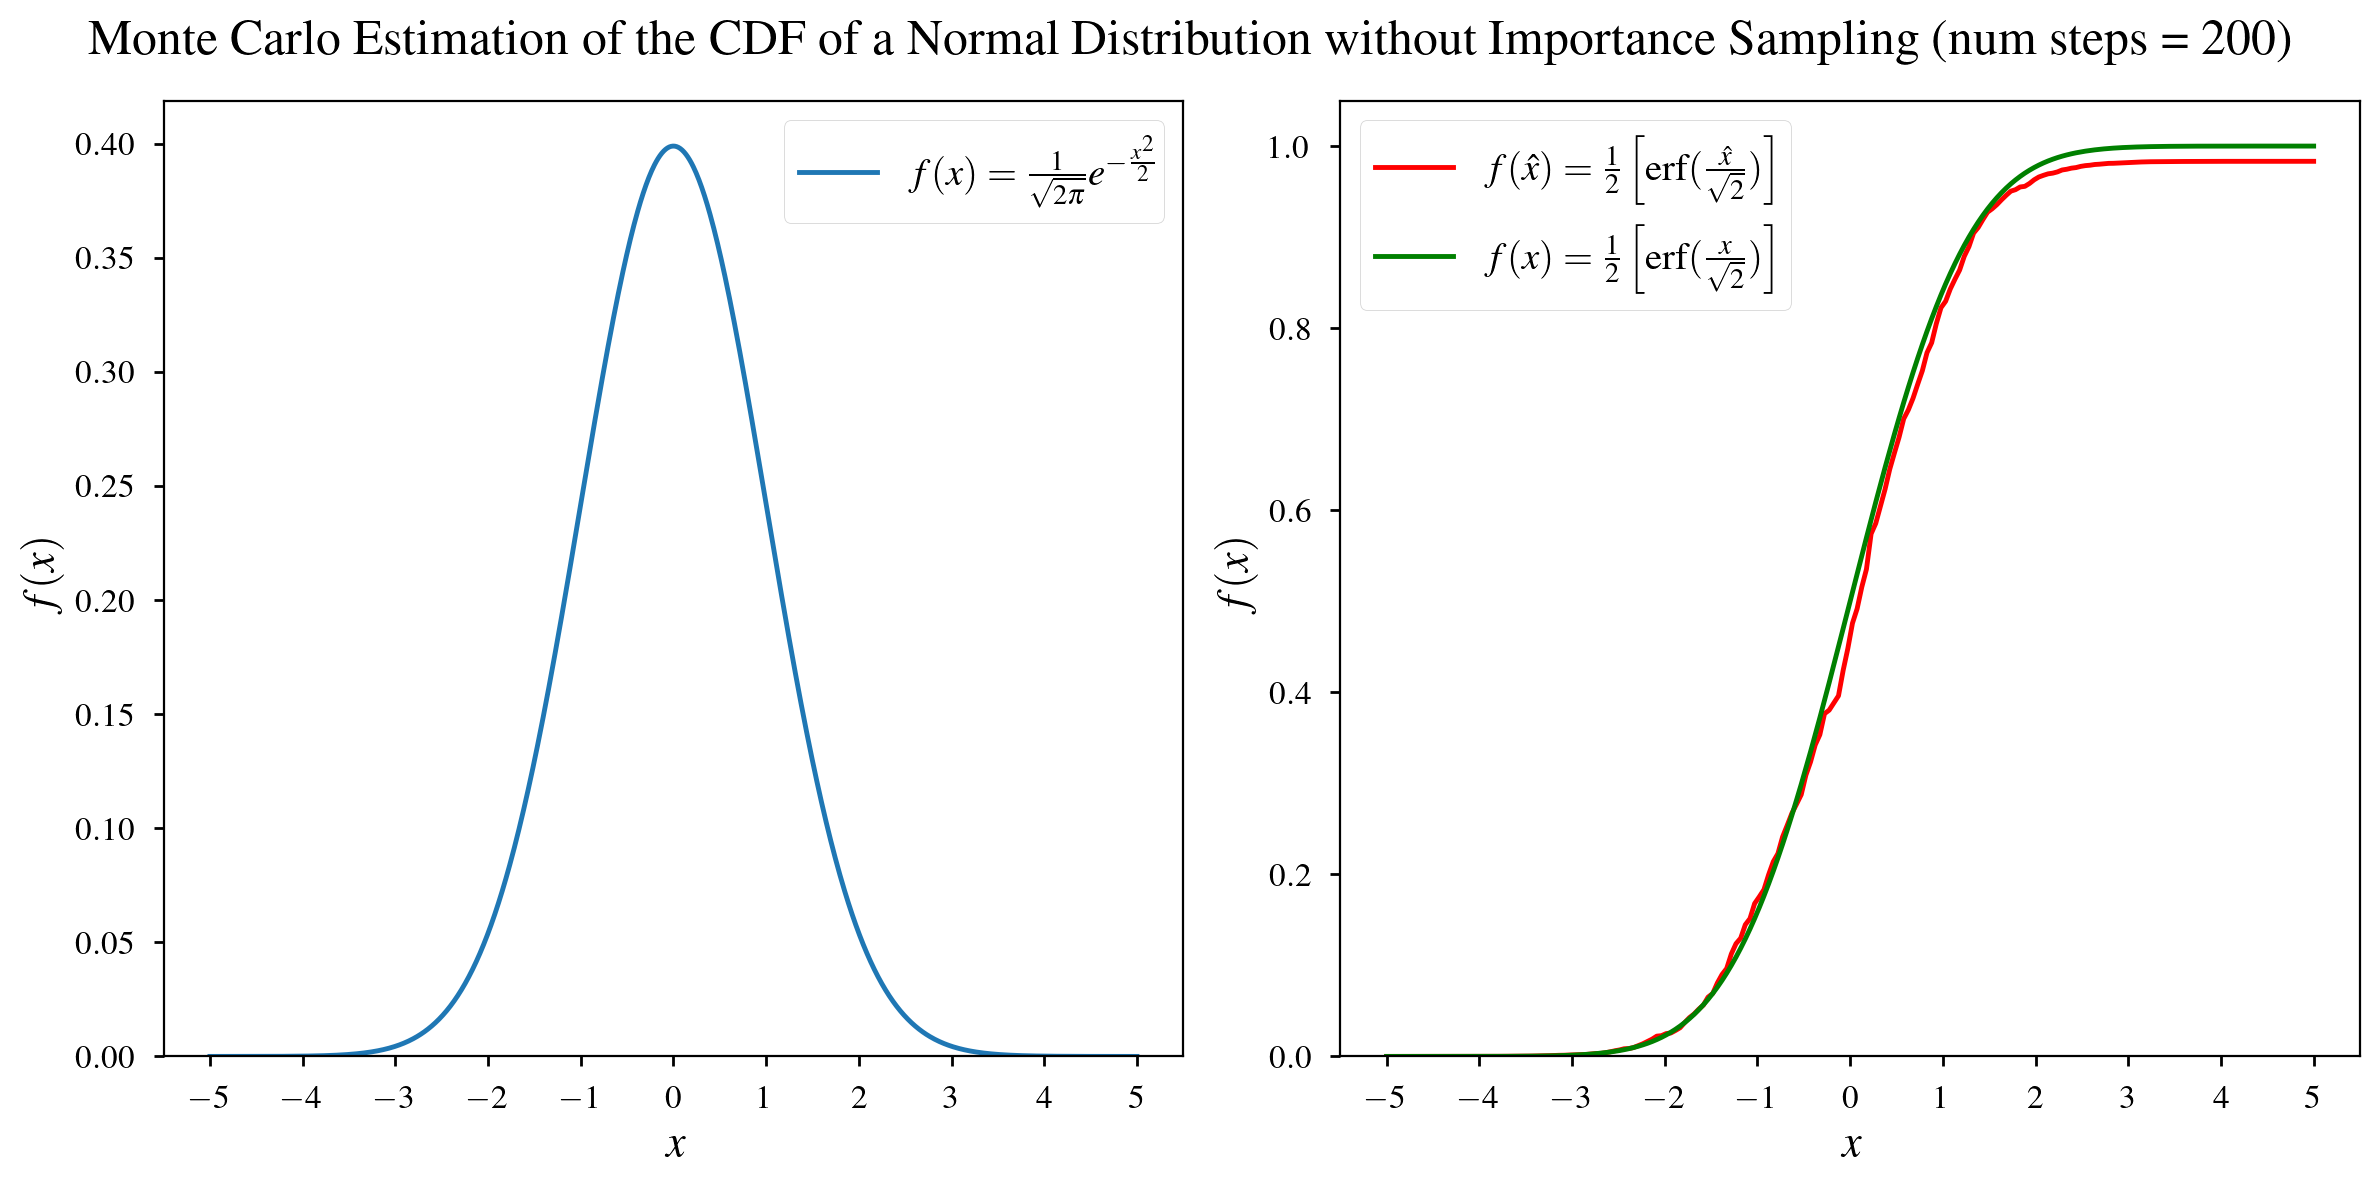

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
fig.suptitle(
    f"Monte Carlo Estimation of the CDF of a Normal Distribution without Importance Sampling (num steps = {num_steps})",
    fontsize=18,
)

x = np.linspace(lower_bound, upper_bound, 1000)
y = func(x)
axs[0].plot(x, y, label=r"$f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$")
axs[0].set_xticks(np.arange(lower_bound, upper_bound + 1, 1))
axs[0].set_ylim(0)
axs[0].tick_params(axis="both", which="major", labelsize=12)
axs[0].set_xlabel(r"$x$", fontsize=16)
axs[0].set_ylabel(r"$f(x)$", fontsize=16)
axs[0].legend(fontsize=14)

x = np.linspace(lower_bound, upper_bound, num_steps)
axs[1].plot(
    x,
    cdf,
    label=r"$f(\hat{x}) = \frac{1}{2} \left[ \text{erf} (\frac{\hat{x}}{\sqrt 2} )\right]$",
    color="r",
)
axs[1].plot(
    x,
    stats.norm.cdf(x, loc=0, scale=1),
    label=r"$f(x) = \frac{1}{2} \left[ \text{erf} (\frac{x}{\sqrt 2} )\right]$",
    color="g",
)
axs[1].set_xticks(np.arange(lower_bound, upper_bound + 1, 1))
axs[1].set_ylim(0)
axs[1].tick_params(axis="both", which="major", labelsize=12)
axs[1].set_xlabel(r"$x$", fontsize=16)
axs[1].set_ylabel(r"$f(x)$", fontsize=16)
axs[1].legend(fontsize=14)

To converge faster we can utilize Monte Carlo with Importance Sampling (IS). The idea is to sample from a distribution that is similar to the function we are trying to integrate. In this case, we can sample from the standard normal distribution. The formula for IS is given by:

\begin{equation*}
\hat{E}[h(X)] = \hat{E}\left[\frac{h(Y)f_X(Y)}{g_Y(Y)}\right]
\end{equation*}

\begin{equation*}
= \frac{1}{N} \sum_{i=1}^{N} \frac{h(y_i)f_X(y_i)}{g_Y(y_i)}
\end{equation*}

where:

- $f_X$ is the p.d.f. of the target distribution
- $h_Y$ is an indicator function with value 1 if $X$ is in the region of interest (bounds of integration) and 0 otherwise
- $g_Y$ is the p.d.f. of the importance distribution
- $\frac{f_X(X)}{g_Y(X)}$ is called the importance weight


In [6]:
step_size = 0.05
lower_bound = -5
upper_bound = 5
num_steps = int((upper_bound - lower_bound) / step_size)
prior = NormalPrior(loc=0, scale=1)
cdf = np.zeros(num_steps)
for i in range(num_steps):
    new_a = lower_bound + step_size * i
    new_b = lower_bound + step_size * (i + 1)
    sampler.initialize(
        new_a,
        new_b,
        prior=prior,
        n_steps=1000,
    )
    pred = sampler.sample()
    cdf[i] = pred + cdf[i - 1] if i > 0 else pred

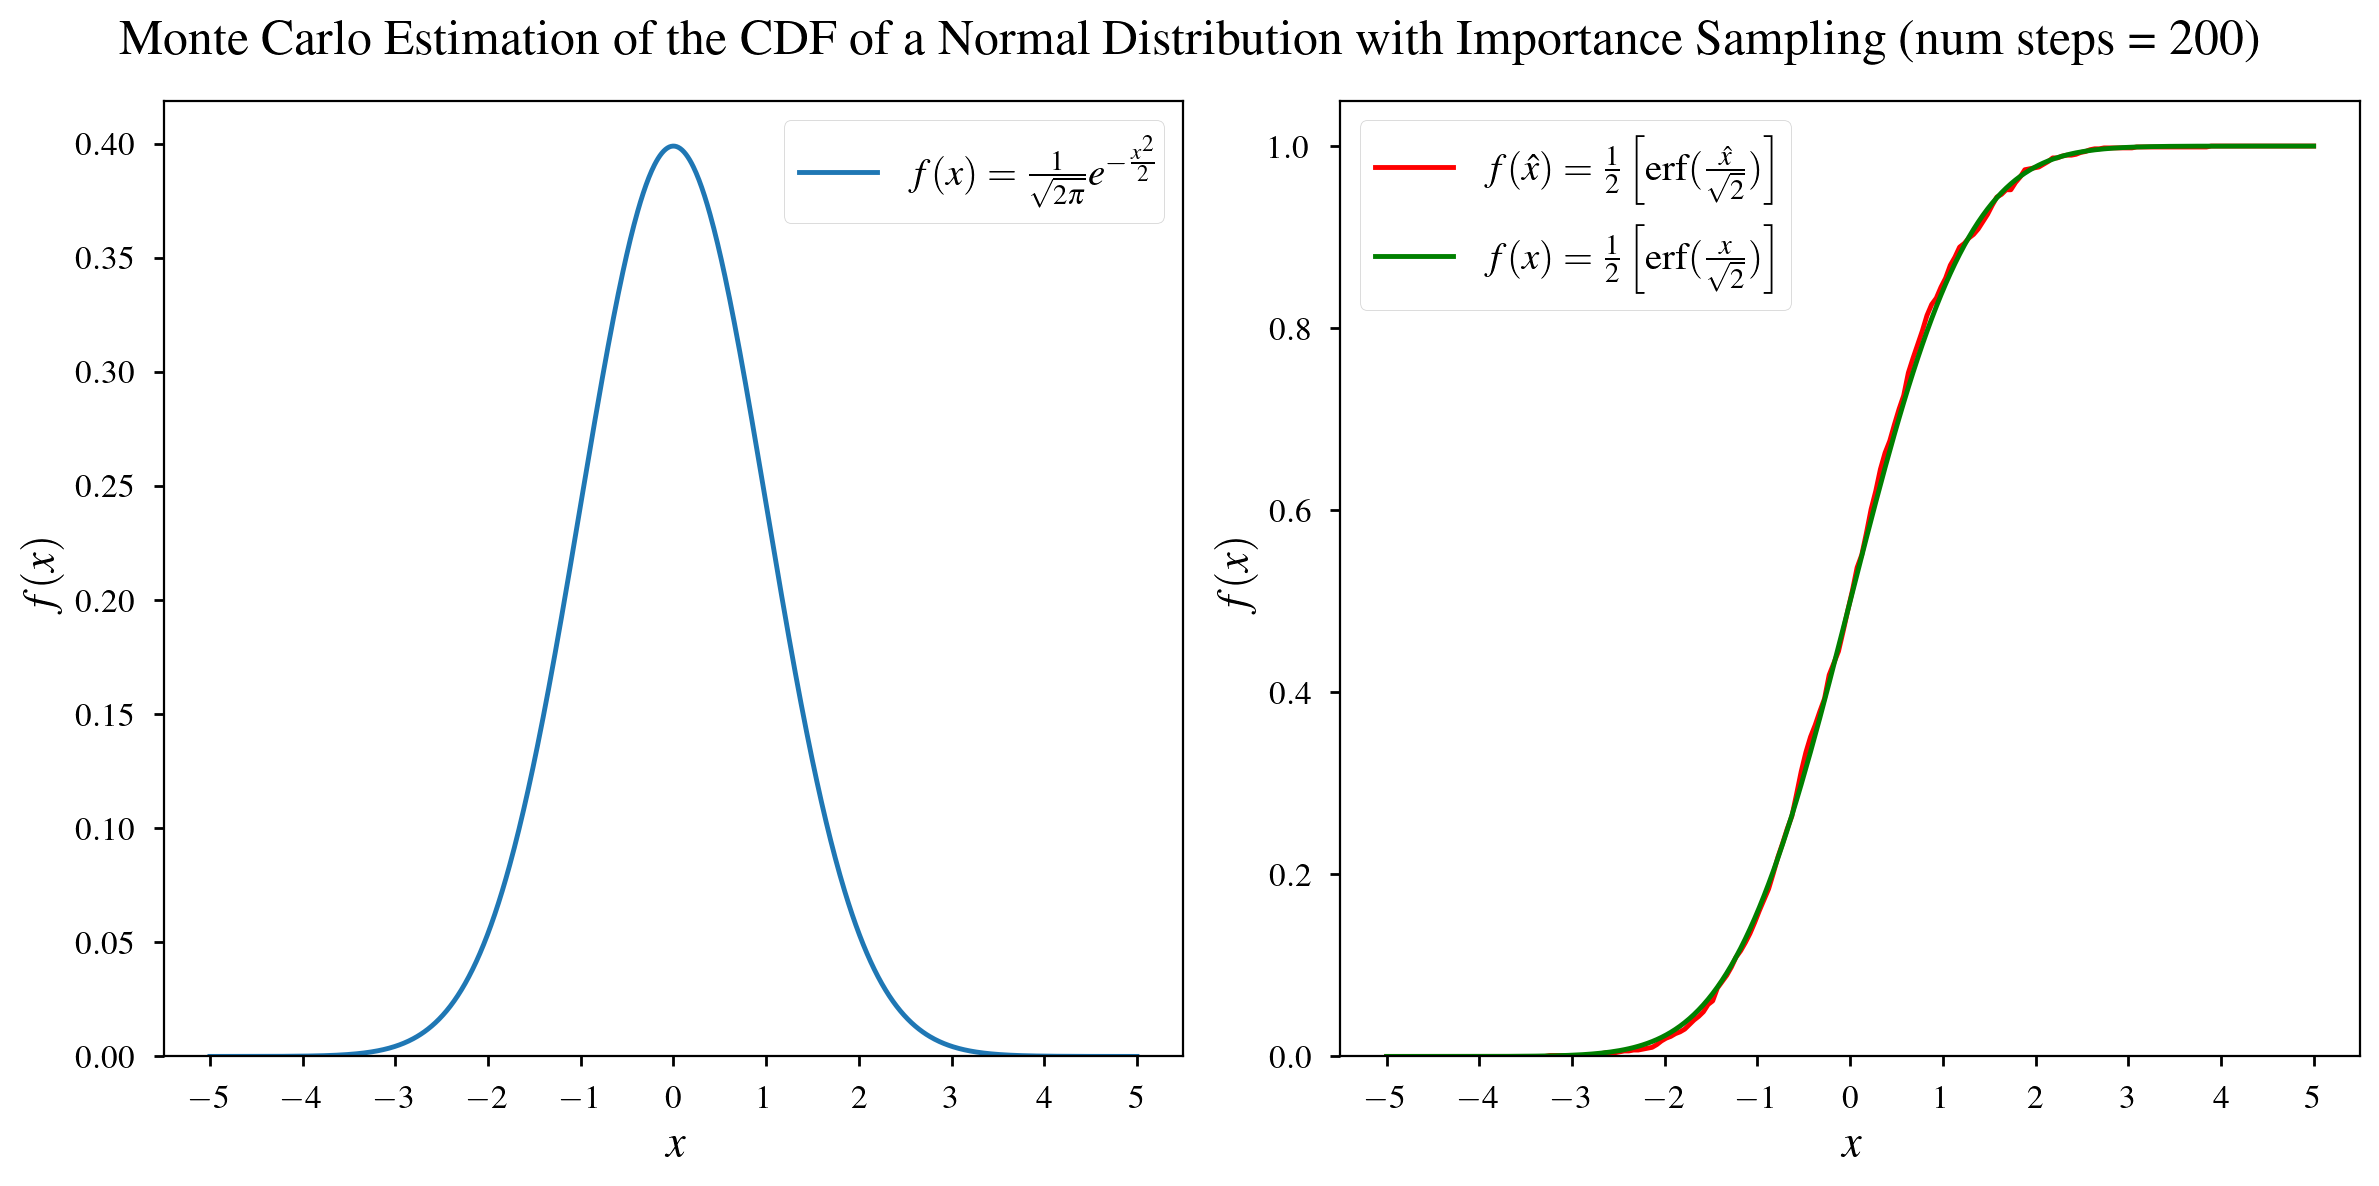

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
fig.suptitle(
    f"Monte Carlo Estimation of the CDF of a Normal Distribution with Importance Sampling (num steps = {num_steps})",
    fontsize=18,
)

x = np.linspace(lower_bound, upper_bound, 1000)
y = func(x)
axs[0].plot(x, y, label=r"$f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$")
axs[0].set_xticks(np.arange(lower_bound, upper_bound + 1, 1))
axs[0].set_ylim(0)
axs[0].tick_params(axis="both", which="major", labelsize=12)
axs[0].set_xlabel(r"$x$", fontsize=16)
axs[0].set_ylabel(r"$f(x)$", fontsize=16)
axs[0].legend(fontsize=14)

x = np.linspace(lower_bound, upper_bound, num_steps)
axs[1].plot(
    x,
    cdf,
    label=r"$f(\hat{x}) = \frac{1}{2} \left[ \text{erf} (\frac{\hat{x}}{\sqrt 2} )\right]$",
    color="r",
)
axs[1].plot(
    x,
    stats.norm.cdf(x, loc=0, scale=1),
    label=r"$f(x) = \frac{1}{2} \left[ \text{erf} (\frac{x}{\sqrt 2} )\right]$",
    color="g",
)
axs[1].set_xticks(np.arange(lower_bound, upper_bound + 1, 1))
axs[1].set_ylim(0)
axs[1].tick_params(axis="both", which="major", labelsize=12)
axs[1].set_xlabel(r"$x$", fontsize=16)
axs[1].set_ylabel(r"$f(x)$", fontsize=16)
axs[1].legend(fontsize=14)

## Volume of an $n$-ball 🎱

References:

- https://en.wikipedia.org/wiki/Volume_of_an_n-ball

The volume of an $n$-ball of radius $r$ is given by the formula:

\begin{equation*}
V_n = \frac{\pi^{n/2}}{\Gamma(n/2+1)} r^n
\end{equation*}

where $\Gamma$ is the gamma function.


We can estimate the volume of an $n$-ball using Monte Carlo integration. The idea is to sample points uniformly from a hypercube that contains the $n$-ball and then count the fraction of points that fall inside the $n$-ball. The volume of the $n$-ball is then approximately the fraction of points that fall inside the $n$-ball times the volume of the hypercube or:

\begin{equation*}
V*n \approx \frac{2^n}{N} \sum*{i=1}^N f(x_i)
\end{equation*}

where $N$ is the number of points, $x_i$ are the points sampled uniformly from the hypercube, and $f(x_i)$ is the indicator function that is 1 if the point falls inside the $n$-ball and 0 otherwise.


Let's see how this works in practice with a simple example in 2D.


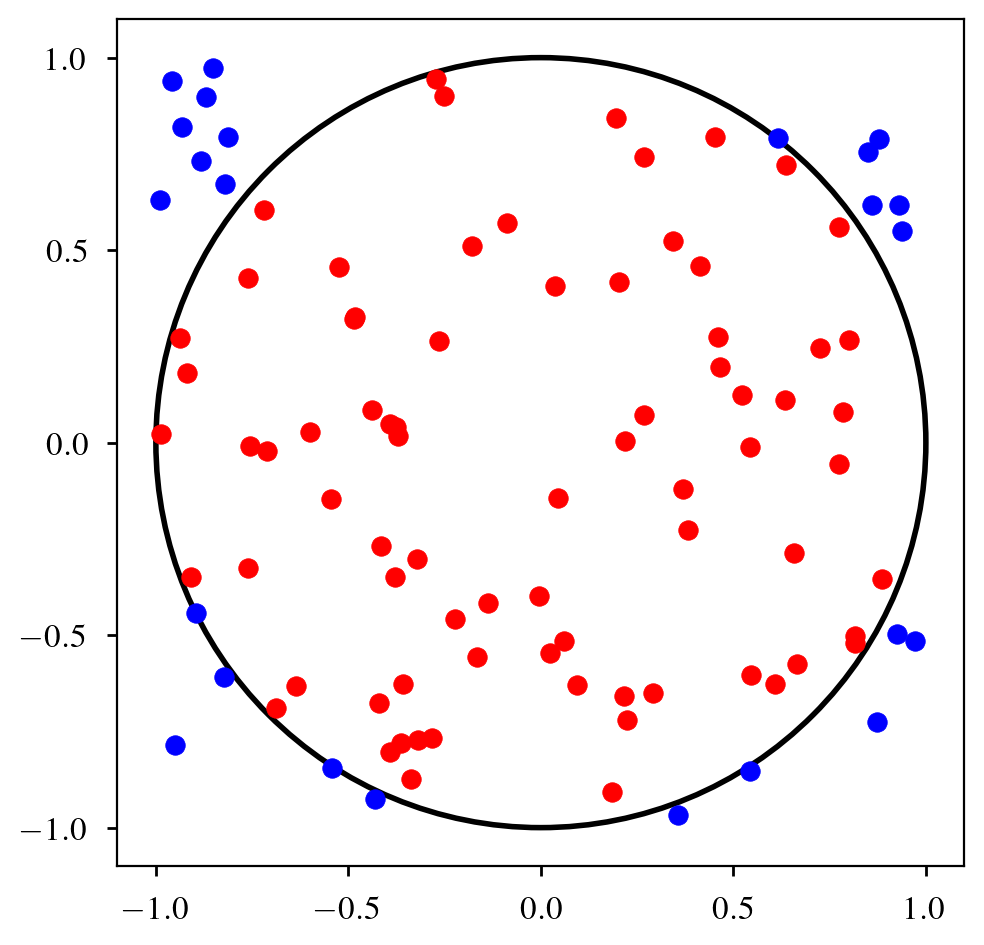

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(Circle((0, 0), 1, fill=False, color="black", linewidth=2))
ax.set_xticks(np.arange(-1, 2, 0.5))
ax.set_yticks(np.arange(-1, 2, 0.5))
ax.tick_params(axis="both", which="major", labelsize=12)

ax.set_aspect("equal")

x = stats.uniform.rvs(loc=-1, scale=2, size=(100, 2), random_state=42)

inside = np.linalg.norm(x, axis=1) < 1

ax.scatter(x[inside, 0], x[inside, 1], color="r")
ax.scatter(x[~inside, 0], x[~inside, 1], color="b")

Now let's expand to $n$ dimensions and see how the volume of the $n$-ball converges to the true value as we increase the number of points.


In [9]:
volumes = {"dimension": [], "pred": [], "true": []}
num_dims = 25
for d in trange(0, num_dims):
    volumes["dimension"].append(d)
    volumes["pred"].append(volume_ball_monte_carlo(d=d, r=1, n=1000000))
    volumes["true"].append(volume_ball_analytical(d=d, r=1))

volumes = pd.DataFrame(volumes, index=range(num_dims))

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
volumes

,dimension,pred,true
0,0,1.000000,1.000000
1,1,2.000000,2.000000
2,2,3.141952,3.141593
3,3,4.191192,4.188790
4,4,4.939408,4.934802
5,5,5.271904,5.263789
6,6,5.141376,5.167713
7,7,4.752640,4.724766
8,8,4.020736,4.058712
9,9,3.339264,3.298509


Notice how as the number of dimensions increases, after 16 dimensions, the volume of the $n$-ball is almost zero. This is because the volume of the hypercube is 1 and the volume of the $n$-ball is almost zero, so the fraction of points that fall inside the $n$-ball is almost zero. This is known as the curse of dimensionality. We can use more sophisticated approaches such as Markov Chain Monte Carlo (MCMC) to estimate the volume of the $n$-ball in high dimensions.
